<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/faster_rcnn/face_detection/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/Kat-ies/Coursework.git
!git clone --single-branch --branch faster_rcnn https://github.com/Kat-ies/Coursework.git
%cd Coursework/src
%run for_google_drive.py

In [2]:
from data_loader import unpacking_zips

unpacking_zips()

# Шаг 1.
Сделаем свой класс, который красиво склеит мои картинки и рамки из прошлой работы и подсунет их торчу в том виде, в котором ему надо (интернет сказал, что именно таким способом предобученным моделям подают свои датасеты).   
Вроде как в target  моим сеткам нужны только boxes и labels.


тут вроде всё работает, только я не доконца разобралась с transform, я так поняла, что в примерах дополнительно подключают [такой модуль](https://github.com/pytorch/vision/blob/master/references/detection/transforms.py), но я не знаю, нужен ли он мне, если не поворачивать изображения, поэтому я в transform я засунула только конвертацию изображения в тензор и нормализацию. 

In [3]:
from PIL import Image 
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class MyDataset(Dataset):
    def __init__(self, images, frames, transforms=None):
        self.images = images
        self.frames = frames
        self.keys_list = list(images.keys())
        self.transforms = transforms
 
    def __getitem__(self, idx):
        img = self.images[self.keys_list[idx]]

        boxes = []
        labels = np.ones(len(self.frames[self.keys_list[idx]]))

            
        for rects in self.frames[self.keys_list[idx]]:
            boxes.append([rects.x, rects.y, rects.x + rects.w, rects.y + rects.h])
                
        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)   
             
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
 
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
            # img, target = self.transforms(img, target)
            img = self.transforms(img)
 
        return img, target
 
    def __len__(self):
        return len(self.images)


О, я придумала, что делать с transforms. Можно сделать вариант с поворотом и без поворота, чтобы оценить, насколько сильно это помогло (или не помогло).

In [4]:
train_transforms = transforms.Compose([# transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([ transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [5]:
from feature_creation.images_and_frames import *
from face_detection.utils import collate_fn
import sklearn.model_selection as sk
import random

RANDOM_SEED = 42


# поскольку картинки и рамки я уже когда-то юзала, то можно снова взять эти функции
dict_images = make_images_dict(is_color=True, max_dict_size= 9000)



dict_frames = make_frames_dict(dict_images)


# здесь начинаются небольшие танцы с бубном, тк нейросеть
# не принимает рамки, вырожденные в точку или в прямую
keys_list = list(dict_frames.keys())
for key in keys_list:
    for rects in dict_frames[key]:
        if rects == Rectangle(0,0,0,0) or rects.w == 0 or rects.h == 0:
            if key in dict_frames:
                del dict_frames[key]
            if key in dict_images:
                del dict_images[key]


train_dataset = MyDataset(dict_images, dict_frames, transforms=train_transforms)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn)

# на вид вывод похож на правду
# train_dataset[0]

# Finetuning 
Может не с первого раза, но с этой частью я разобралась. Если я всё праивльно поняла, то моя задача заменить число классов выходного слоя (1 класс + фон, т.е всего 2 класса) и дообучить модель на датасете, где все labels будут 1. 

In [6]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
      
def get_object_detection_model():
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has num_classes which is user-defined
    num_classes = 2  # 1 + background
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
 

In [7]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_object_detection_model()
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# Дообучение модели 

Настройка всех параметров завершена, поэтому осталось только сделать `train` и наслаждаться жизнью. 

Я могла бы сделать это вручную, но у торча есть прекрасный гитхаб с полезными функциями, которые выводят даже какую-то статистику (в принципе можно ещё график построить, как в прошлый раз). Поэтому я взяла всё нужное где-то тут https://github.com/pytorch/vision и сохранила отдельным файлом.

Я не писала всё сама, тк подумала, что если всё же получится потренировать сетки в Google Cloud, то там можно будет попробовать понастраивать какие-нибудь параметры, которые в колабе недоступны (например, число  gpu). А сделать эти настройки в готовой функции проще, чем в своей собственной :)


In [ ]:
from face_detection.train_one_epoch import train_one_epoch
from data_saver import save_nn_model
import math

num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()


# def save_nn_model(param, name, path=PATH, folder='Networks'):
#   torch.save(param, os.path.join(path, folder, name + '.pth'))

PATH = '/content/drive/MyDrive/КУ Курсачи/Курсовая работа 2021/'

save_nn_model(model.state_dict(),'faster_rcnn', path=PATH, folder='Models')

# **О боже оно работает!!!**

Что делать, если в 5 утра заработала нейронка? - Конечно же, поиграться с ней и попрогонять все картинки, что есть под рукой!

*P.S. я, конечно, могу сказать, что все снимки ниже подобраны так, чтобы посмотреть разные случаи и всё такое, но фраза "посмотрите, что у меня есть" прозвучит куда убедительнее :)*  

*P.P.S. я ещё решила повыводить `score`, потому что во время самой первой попытки на снимке со мной была рамочка у меня и возле меня. Только вот там никого не было...*  



In [38]:
import os
from data_loader import load_nn_model

files = os.listdir(os.path.join(PATH, 'images'))
files.sort()

images = []
predictions = []


model = get_object_detection_model()
model.to(device)
model.load_state_dict(load_nn_model('faster_rcnn', path=PATH, folder='Models'))

for file in files:
    image = Image.open(os.path.join(PATH, 'images', file))
    img = train_transforms(image)
    images.append(image)

    model.eval()
    with torch.no_grad():
       prediction = model([img.to(device)])
    predictions.append(prediction)

In [39]:
from PIL import Image, ImageDraw 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


def show_predictions(images, predictions, titles):

    fig = plt.figure(figsize=(60, 70))
    cols = 1
    rows = len(images)

    # ax enables access to manipulate each of subplots
    ax = []
    i = 0
   
    for image, prediction, title in zip(images, predictions, titles):

        boxes = list(prediction[0]['boxes'].cpu().numpy())
        scores = list(prediction[0]['scores'].cpu().numpy())
        

        ax.append(fig.add_subplot(rows, cols, i + 1))
        ax[-1].set_title(title)
        i += 1

        for box, score in zip(boxes, scores):
            img1 = ImageDraw.Draw(image)   
            img1.rectangle(box, fill =None, outline ="red") 

            img2 = ImageDraw.Draw(image)
            img2.rectangle((box[0],box[1],box[0]+65,box[1]+14), fill ='black', outline ="black") 

            img3 = ImageDraw.Draw(image)
            img3.text((box[0],box[1]),'score: '+f"{score:.{2}f}")


        plt.imshow(image)

    plt.show()  # finally, render the plot


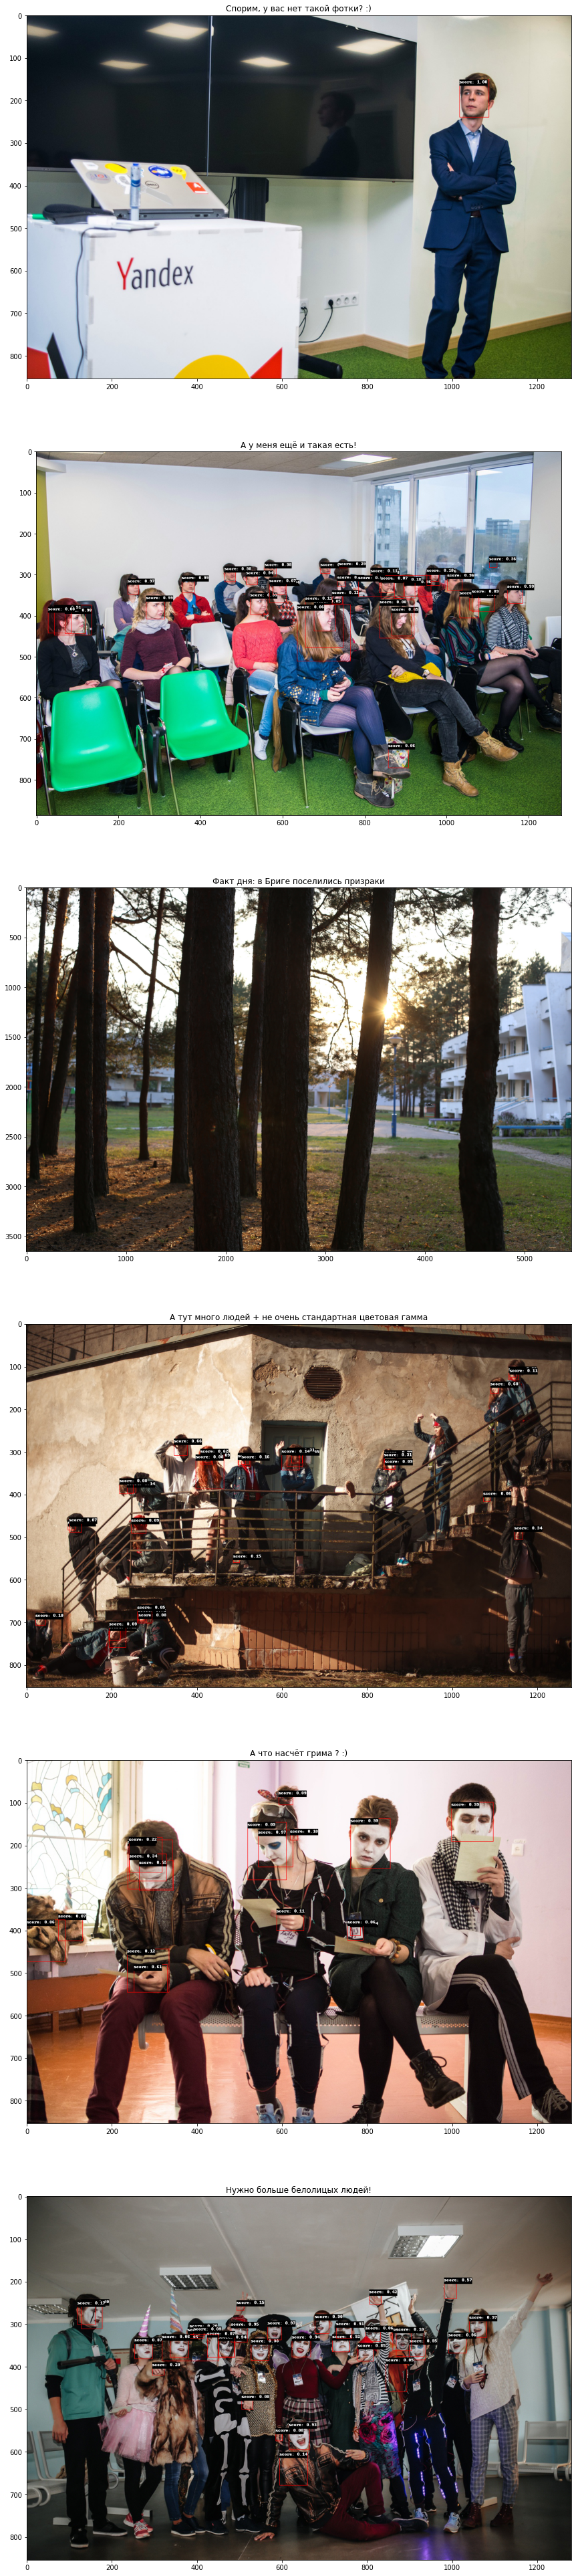

In [40]:
show_predictions(images, predictions, titles)

# **Планы на будущее**

*(я больше писала это для себя, чтобы ничего не забыть, но вдруг вам тоже будет интересно :) ).*

План А на ближайщее будущее:

1. Добавить тестовую выборку, чтобы можно было оценить, например, `accuracy_score` и понять, насколько хорошо обучилась модель, нужно ли пытаться увеличить объём обучающей выборки и тд...

2. Провернуть то же самое для `RetinaNet` и метода Виолы-Джонса (реализация в cv)

3. Придумать, как это всё красиво структурировать, чтобы это было похоже на красивый проект, а не на рандомные куски кода.

План В (выполнять после плана А):

0. Обучить `Faster RCNN` и `RetinaNet` с 0. Можно взять готовые модели с параметром `pretrained=False` или посмотреть, какие там слои ( вроде как эта информация общедоступна) и прописать их явно. Может я не права, но оба способа выглядят, как одно и то же. 

1. (???) Построить свой метод Виолы-Джонса, используя классификатор из прошлой работы (Звучит как план энтузиаста, но наверное это реально сделать)

2. Сравнить результаты с нейронками из плана А.

3. Построить красивый визуал. Идея: взять пару картинок и прогнать каждое изображение через все сетки и вывести, чтобы посмотреть, как сетки справились с детекцией (таблицы с чиселками - это круто и очень по-научному, но как показал последний опыт, людям намного интереснее смотреть красивые картинки, чем таблички с кучей цифр:) ).

4. Убедиться, что всё работает, как надо, и раснести весь код по файлам, а в ноутбука оставить только визуал + таблички и прочие интересности.

5. Наслаждаться проделанной работой :)

# Ещё планы, чтобы не забыть:

1. Поиграться с transform   

2. не загружать датасет в оперативку. Вместо этого один раз отдельно всё загрузить, поделить на train и test, и сохранить в таком виде.


In [22]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar 22 01:25:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |  14190MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
titles = [
          'Спорим, у вас нет такой фотки? :)',
          'А у меня ещё и такая есть!',
          'Факт дня: в Бриге поселились призраки',
          'А тут много людей + не очень стандартная цветовая гамма',
          'А что насчёт грима ? :)',
          'Нужно больше белолицых людей!',
]